In [1]:
! pip install --quiet gensim

In [1]:
import pandas as pd

yelps = pd.read_csv('sentiment/yelps.csv')

In [2]:
from bs4 import BeautifulSoup
from spacy.lang.en import English

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now.   
    parser = English()
    tokens = parser(s)
    tokens = [token.orth_ for token in tokens if not token.orth_.isspace()]
    return tokens

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Create a count vectorizer, using the preprocessor and tokenizer from above
# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD

vectorizer = CountVectorizer(preprocessor=clean_yelp, tokenizer=tokenize)

# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
V = vectorizer.fit_transform(yelps.text)
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD
svd = TruncatedSVD(n_components=100)
PCA_V = svd.fit_transform(V)

/home/arilam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/arilam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

In [26]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 
cutoffs = [60000,70000,80000,90000]
for val in cutoffs:
    print("cutoff:",val,"accuracy:",test_holdout_vectors(PCA_V, yelps.positive, val))

/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 60000 accuracy: 0.666375


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 70000 accuracy: 0.7684


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 80000 accuracy: 0.81995


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 90000 accuracy: 0.8555


In [4]:
import multiprocessing
cores = multiprocessing.cpu_count()
sentences = pd.Series([])
for val in yelps.text:
    sentences = sentences.append(pd.Series([tokenize(clean_yelp(val))]))

/home/arilam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/arilam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [5]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!
w2v = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 
w2v.build_vocab(sentences)
w2v.train(sentences, total_examples=w2v.corpus_count, epochs=30)

(143022177, 407646420)

In [6]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a


# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [7]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

# Yes, word2vec is better. The higher the cutoff value, the better.
cutoffs = [60000,70000,80000,90000]
for val in cutoffs:
    print("cutoff:",val,"accuracy:",test_holdout_vectors(np.array([embed_w2v(t, w2v) for t in sentences]), yelps.positive, val))

/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 60000 accuracy: 0.8467


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 70000 accuracy: 0.9058333333333334


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 80000 accuracy: 0.9301


/home/arilam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


cutoff: 90000 accuracy: 0.9426


In [8]:
import pandas as pd
import re
from functools import reduce

pats = [re.compile(r'https?:\/\/[^\s]+'), 
        re.compile(r'rt\s*@\w+\s?:?'),
        re.compile(r'@\w+')]

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!

    # BONUS: Try using the library "spacy" to 
    # do further processing, such as lemmatizing
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    import spacy
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(clean(s))
    s = ' '.join([token.lemma_ for token in doc])
    return s

import re
def clean(tweet):
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)  # URLs
    tweet = re.sub(r'RT', '', tweet)  # RTs
    tweet = re.sub(r'(?:@[\w_]+)', '', tweet)  # user-mentions
    tweet = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)', '', tweet)  # hashtags
    tweet = re.sub(r'(?:(?:\d+,?)+(?:\.?\d+)?)', '', tweet)  # numbers
    return tweet

In [37]:
# Load tweet!
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [38]:
for val in tweets:
    sentences = sentences.append(pd.Series([tokenize(clean_twitter(val))]))

In [39]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
# 
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v.corpus_count, epochs=30)
print("Word2Vec:",w2v_model.wv.most_similar(positive=["hillary"], negative=["trump"]))

Word2Vec: [('promptly', 0.39917662739753723), ('swiftly', 0.39584147930145264), ('corona', 0.38171905279159546), ('bartender', 0.37450915575027466), ('immediately', 0.37206289172172546), ('luke', 0.3644936680793762), ('brittany', 0.3576115369796753), ('differently', 0.3574785590171814), ('barista', 0.3521344065666199), ('server', 0.34899580478668213)]


/home/arilam/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [40]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

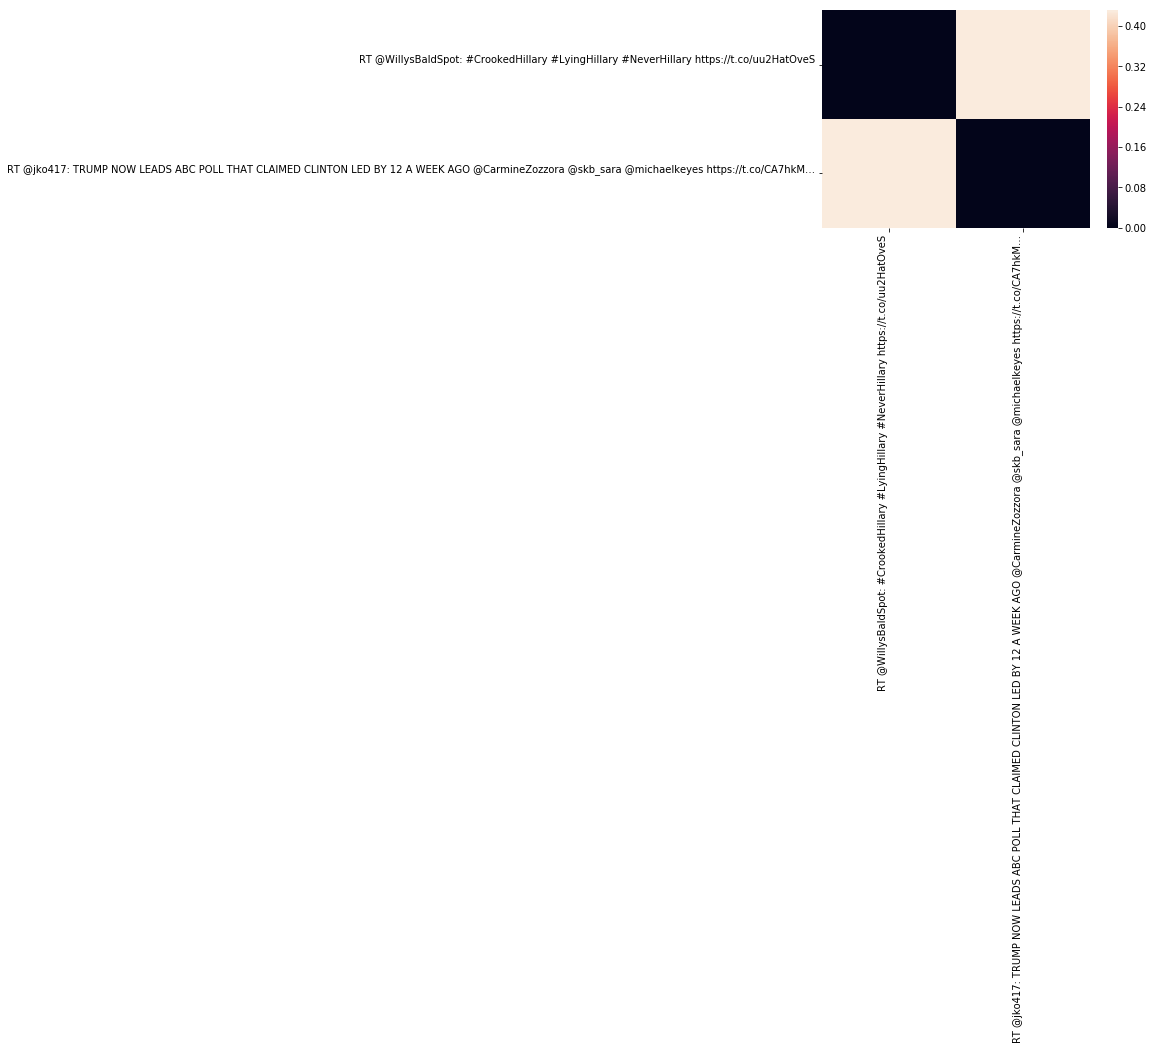

In [46]:
vectorizer = CountVectorizer()
V = vectorizer.fit_transform(tweets)
svd = TruncatedSVD(n_components=100)
PCA_V = svd.fit_transform(V)
visualize_dist(PCA_V,tweets,[1,2])

In [47]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data